In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 1: Fine-tune Chemical Language Model

The goal is to fine-tune a pre-trained chemical language model on a regression task using the Lipophilicity dataset. The task involves predicting the lipophilicity value for a given molecule representation (SMILES string). You will learn how to load and tokenize a dataset from HuggingFace, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [3]:
# import dependencies
import torch
import datasets
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoConfig, AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, TrainingArguments
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import random
from sklearn.metrics import mean_squared_error, r2_score
from transformers.models.auto.modeling_auto import MODEL_MAPPING_NAMES
import matplotlib.pyplot as plt
import math
import numpy as np


# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [4]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [5]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

lipophilicity.csv:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4200 [00:00<?, ? examples/s]

In [6]:
# Explore the dataset
# For example, print the column names and display a few sample rows
# TODO: your code goes here
print("Columns:", dataset['train'].column_names)
print("Sample rows:")
print(dataset['train'][:5])


Columns: ['SMILES', 'label']
Sample rows:
{'SMILES': ['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', 'COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', 'COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl', 'OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3', 'Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)NCC#N)c1'], 'label': [3.54, -1.18, 3.69, 3.37, 3.1]}


In [7]:
# define a PyTorch Dataset class for handling SMILES strings and targets

# TODO: your code goes here
# class SMILESDataset(Dataset):
class SMILESDataset(Dataset):
    def __init__(self, smiles, targets):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        # Access elements using .iloc to ensure positional indexing
        smiles = self.smiles.iloc[idx]
        target = self.targets.iloc[idx]
        encoding = self.tokenizer(smiles, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'target': torch.tensor(target, dtype=torch.float32)
        }





## --- Step 2: Split Dataset ---

As there is only one split (train split) in the original dataset, we need to split the data into training and testing sets by ourselves.

In [8]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [9]:
# split the data into training and test datasets
# TODO: your code goes here
train_df, test_df = train_test_split(dataset['train'].to_pandas(), test_size=0.2, random_state=42)

In [10]:
# construct Pytorch data loaders for both train and test datasets
BATCH_SIZE = 16 # adjust based on memory constraints

# TODO: your code goes here
train_df = SMILESDataset(train_df['SMILES'], train_df['label'])
train_loader = DataLoader(train_df, batch_size=BATCH_SIZE, shuffle=True)
test_df = SMILESDataset(test_df['SMILES'], test_df['label'])
test_loader = DataLoader(test_df, batch_size=BATCH_SIZE, shuffle=False)



## --- Step 3: Load Model ---

In [11]:
# load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

In [12]:
# We need to add a regression head on the language model as we are doing a regression task.

# specify model with a regression head

class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, base_model):
        super(MoLFormerWithRegressionHead, self).__init__()
        self.base_model = base_model
        self.regressor = nn.Linear(base_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        # Ensure we get the hidden states
        hidden_states = outputs.last_hidden_state  # shape: [batch_size, seq_length, hidden_size]
        # Use the CLS token representation (assuming it's at index 0)
        cls_token = hidden_states[:, 0, :]
        regression_output = self.regressor(cls_token)
        return regression_output


In [13]:
# initialize the regression model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_model = MoLFormerWithRegressionHead(model).to(device)
print(device)

cuda


## --- Step 4: Training ---

Epoch 1/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1/15, Average Loss (MSE): 1.3271


Epoch 2/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2/15, Average Loss (MSE): 0.8082


Epoch 3/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3/15, Average Loss (MSE): 0.6035


Epoch 4/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4/15, Average Loss (MSE): 0.4923


Epoch 5/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5/15, Average Loss (MSE): 0.4238


Epoch 6/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6/15, Average Loss (MSE): 0.3665


Epoch 7/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 7/15, Average Loss (MSE): 0.3321


Epoch 8/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8/15, Average Loss (MSE): 0.3002


Epoch 9/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 9/15, Average Loss (MSE): 0.2739


Epoch 10/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 10/15, Average Loss (MSE): 0.2514


Epoch 11/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 11/15, Average Loss (MSE): 0.2374


Epoch 12/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 12/15, Average Loss (MSE): 0.2152


Epoch 13/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 13/15, Average Loss (MSE): 0.1963


Epoch 14/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 14/15, Average Loss (MSE): 0.1912


Epoch 15/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 15/15, Average Loss (MSE): 0.1862


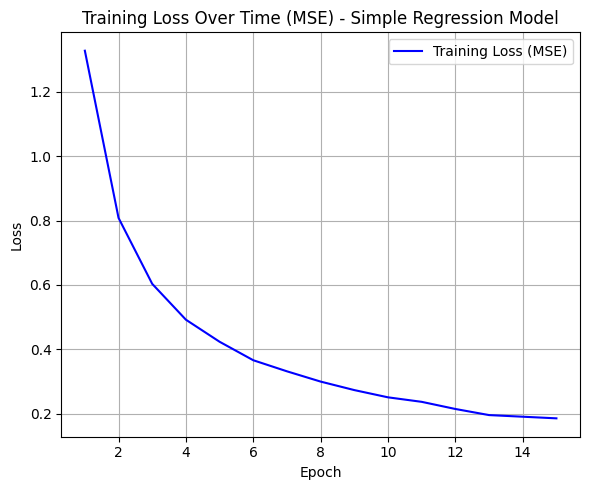

In [17]:
# TODO: your code goes here
optimizer = torch.optim.AdamW(regression_model.parameters(), lr=1e-5)
criterion = nn.MSELoss()
epochs = 15

# Initialize list to track training losses
train_losses = []

for epoch in range(epochs):
    regression_model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        optimizer.zero_grad()
        logits = regression_model(input_ids, attention_mask)
        loss = criterion(logits.squeeze(), targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss (MSE): {avg_loss:.4f}")

# Create the visualization for training loss only
plt.figure(figsize=(6, 5))
plt.plot(range(1, epochs + 1), train_losses, 'b-', label='Training Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time (MSE) - Simple Regression Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## --- Step 5: Evaluation ---

In [20]:
# TODO: your code goes here

regression_model.eval()
total_loss = 0
all_targets = []
all_predictions = []

try:
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating Test Set"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            # Forward pass
            logits = regression_model(input_ids, attention_mask)

            # Calculate loss
            loss = criterion(logits.squeeze(), targets)
            total_loss += loss.item()

            # Store predictions and targets for R² calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(logits.squeeze().cpu().numpy())

    # Calculate metrics
    average_loss = total_loss / len(test_loader)
    r2 = r2_score(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    rmse = math.sqrt(mse)

    # Print results
    print(f"Average Loss (MSE) on Test Set: {average_loss:.4f}")
    print(f"R² Score on Test Set: {r2:.4f}")
    print(f"RMSE on Test Set: {rmse:.4f}")

except Exception as e:
    print(f"An error occurred during evaluation: {str(e)}")


# Save the model
torch.save(regression_model.state_dict(), "regression_model.pth")

Evaluating Test Set:   0%|          | 0/53 [00:00<?, ?it/s]

Average Loss (MSE) on Test Set: 0.5635
R² Score on Test Set: 0.6257
RMSE on Test Set: 0.7436


# 2.Add Unsupervised Finetuning
In this step, you will perform unsupervised fine-tuning on the training dataset. This means the model will leverage only the SMILES strings without any corresponding labels to adapt its understanding of the data distribution. By familiarizing the model with the patterns and structure of the SMILES strings, you can potentially enhance its performance on downstream supervised tasks.

For this fine-tuning, you will use the Masked Language Modeling (MLM) objective, where the model learns to predict randomly masked tokens within the input sequence. Remember to save the fine-tuned model for later use.


Epoch 1/15:   0%|                                                           | 0/210 [00:00<?, ?it/s]

Epoch 1/15, Average Loss (MSE): 0.1724


Epoch 2/15:   0%|                                                           | 0/210 [00:00<?, ?it/s]

Epoch 2/15, Average Loss (MSE): 0.1673


Epoch 3/15:   0%|                                                           | 0/210 [00:00<?, ?it/s]

Epoch 3/15, Average Loss (MSE): 0.1658


Epoch 4/15:   0%|                                                           | 0/210 [00:00<?, ?it/s]

Epoch 4/15, Average Loss (MSE): 0.1751


Epoch 5/15:   0%|                                                           | 0/210 [00:00<?, ?it/s]

Epoch 5/15, Average Loss (MSE): 0.1652


Epoch 6/15:   0%|                                                           | 0/210 [00:00<?, ?it/s]

Epoch 6/15, Average Loss (MSE): 0.1721


Epoch 7/15:   0%|                                                           | 0/210 [00:00<?, ?it/s]

Epoch 7/15, Average Loss (MSE): 0.1674


Epoch 8/15:   0%|                                                           | 0/210 [00:00<?, ?it/s]

Epoch 8/15, Average Loss (MSE): 0.1707


Epoch 9/15:   0%|                                                           | 0/210 [00:00<?, ?it/s]

Epoch 9/15, Average Loss (MSE): 0.1699


Epoch 10/15:   0%|                                                          | 0/210 [00:00<?, ?it/s]

Epoch 10/15, Average Loss (MSE): 0.1700


Epoch 11/15:   0%|                                                          | 0/210 [00:00<?, ?it/s]

Epoch 11/15, Average Loss (MSE): 0.1708


Epoch 12/15:   0%|                                                          | 0/210 [00:00<?, ?it/s]

Epoch 12/15, Average Loss (MSE): 0.1771


Epoch 13/15:   0%|                                                          | 0/210 [00:00<?, ?it/s]

Epoch 13/15, Average Loss (MSE): 0.1676


Epoch 14/15:   0%|                                                          | 0/210 [00:00<?, ?it/s]

Epoch 14/15, Average Loss (MSE): 0.1690


Epoch 15/15:   0%|                                                          | 0/210 [00:00<?, ?it/s]

Epoch 15/15, Average Loss (MSE): 0.1705


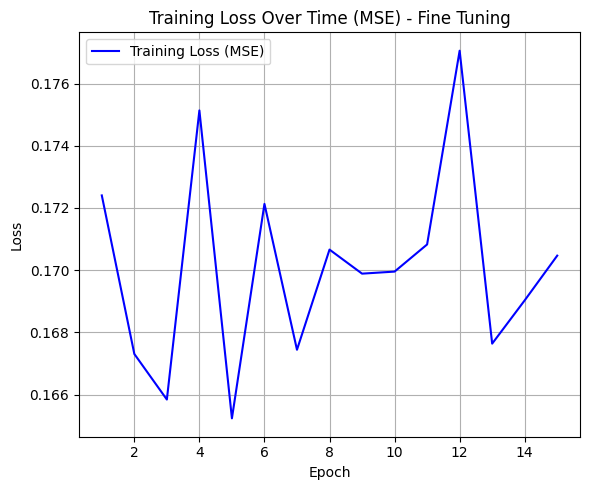

In [21]:
import torch.nn.functional as F



# Define a new dataset class for unsupervised fine-tuning
class UnsupervisedSMILESDataset(Dataset):
    def __init__(self, smiles):
        self.smiles = smiles
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        smiles = self.smiles.iloc[idx]
        encoding = self.tokenizer(smiles, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }



# Prepare the dataset and dataloader
unsupervised_train_dataset = UnsupervisedSMILESDataset(train_df.smiles)
unsupervised_train_loader = DataLoader(unsupervised_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Load the base model from a pretrained checkpoint to build our regression model
original_config = AutoConfig.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)
mlm_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True)
base_model = mlm_model.base_model if hasattr(mlm_model, 'base_model') else mlm_model

# Load the saved state dict and remap keys to match your model's parameters:
saved_state = torch.load('regression_model.pth', weights_only=True)
mapped_state = {}
for key, value in saved_state.items():
    new_key = key.replace('regression_head', 'regressor')
    mapped_state[new_key] = value

regression_model.load_state_dict(mapped_state)


# Initialize regression model and load weights from the saved file
regression_model = MoLFormerWithRegressionHead(base_model).to(device)
regression_model.load_state_dict(torch.load('regression_model.pth', weights_only=True))

# Use the loaded regression model for MLM training
mlm_optimizer = torch.optim.AdamW(regression_model.parameters(), lr=1e-5)
epochs = 15

# Initialize lists to track metrics
total_losses = []
eval_losses = []

# Start training loop
for epoch in range(epochs):
    regression_model.train()
    total_loss = 0

    # Create a tqdm progress bar for the epoch
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", ncols=100)

    # Iterate through training data
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['target'].to(device).float()  # Use 'target' instead of 'labels'

        # Forward pass
        outputs = regression_model(input_ids=input_ids, attention_mask=attention_mask)

        # Assuming the model outputs logits for regression
        logits = outputs

        # If logits has shape [batch_size, seq_length], take the first token (e.g., [CLS])
        if logits.size(1) > 1:
            logits = logits[:, 0]  # Use the first token or apply pooling if needed

        # Ensure the labels have the same shape as logits, [batch_size, 1]
        labels = labels.view(-1, 1)  # Reshape labels to be [batch_size, 1]

        # Compute MSE loss
        loss = F.mse_loss(logits, labels)
        total_loss += loss.item()

        # Update progress bar with current loss
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss (MSE): {avg_loss:.4f}")

    total_losses.append(total_loss / len(train_loader))



# Save the fine-tuned tokenizer and updated regression model
save_dir = "fine-tuned-mlm-model"
regression_model_to_save = regression_model.module if hasattr(regression_model, 'module') else regression_model
#torch.save(regression_model_to_save.state_dict(), 'lm-model-finetuned.pt')
tokenizer.save_pretrained(save_dir)

# Save the full fine-tuned MLM model checkpoint
mlm_model.save_pretrained("fine-tuned-mlm-model")

# Create the visualization for training loss only
plt.figure(figsize=(6, 5))
plt.plot(range(1, epochs + 1), total_losses, 'b-', label='Training Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time (MSE) - Fine Tuning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# 3.Fine-Tune for Comparison
After performing unsupervised fine-tuning on the training data, we now fine-tune the model on the regression task with the regression head. By comparing the performance of the model before and after unsupervised fine-tuning, you can evaluate how the unsupervised fine-tuning impacts the model's performance on our target task.


In [80]:

def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits.squeeze(), targets)

            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(logits.squeeze().cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    r2 = r2_score(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    rmse = math.sqrt(mse)
    return avg_loss, r2, rmse

Epoch 1/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1/15 - Training MSE: 0.5256


Epoch 2/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2/15 - Training MSE: 0.2320


Epoch 3/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3/15 - Training MSE: 0.2024


Epoch 4/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4/15 - Training MSE: 0.1901


Epoch 5/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5/15 - Training MSE: 0.1731


Epoch 6/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6/15 - Training MSE: 0.1649


Epoch 7/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 7/15 - Training MSE: 0.1520


Epoch 8/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8/15 - Training MSE: 0.1446


Epoch 9/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 9/15 - Training MSE: 0.1417


Epoch 10/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 10/15 - Training MSE: 0.1294


Epoch 11/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 11/15 - Training MSE: 0.1253


Epoch 12/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 12/15 - Training MSE: 0.1189


Epoch 13/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 13/15 - Training MSE: 0.1158


Epoch 14/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 14/15 - Training MSE: 0.1162


Epoch 15/15:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 15/15 - Training MSE: 0.1080

Final Results:
Test Loss (MSE): 0.4279
R² Score: 0.7159
RMSE: 0.6479


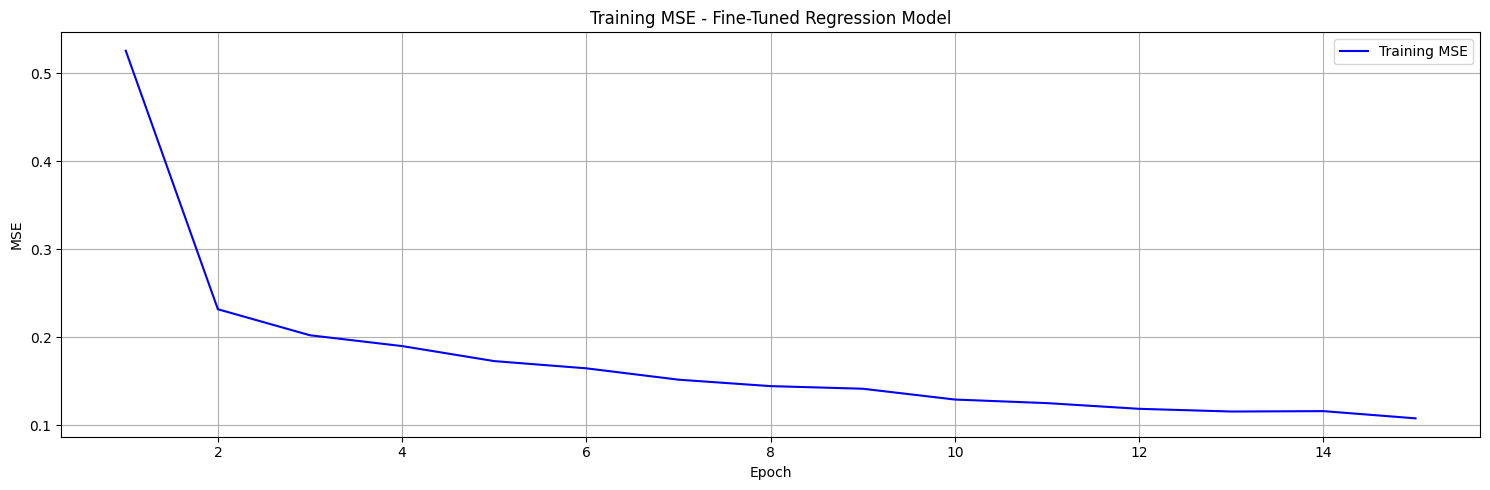

In [23]:
# TODO: your code goes here
# Load the fine-tuned MLM model
# First import the original model's config
original_config = AutoConfig.from_pretrained(
    "ibm/MoLFormer-XL-both-10pct",
    trust_remote_code=True
)
# Load the fine-tuned MLM model with the original config
mlm_model = AutoModelForMaskedLM.from_pretrained(
    "fine-tuned-mlm-model",
    config=original_config,
    trust_remote_code=True,
    ignore_mismatched_sizes=True
)
# Convert to base model if needed
base_model = mlm_model.base_model if hasattr(mlm_model, 'base_model') else mlm_model

# Initialize the regression model
regression_model = MoLFormerWithRegressionHead(base_model).to(device)

# Specify optimizer, scheduler and loss function
optimizer = torch.optim.AdamW(regression_model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.MSELoss()

train_mse_history = []


# Fine-tune the model on the regression task
epochs = 15

try:
    for epoch in range(epochs):
        regression_model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            logits = regression_model(input_ids, attention_mask)
            loss = criterion(logits.squeeze(), targets)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(regression_model.parameters(), max_norm=1.0)

            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        training_mse = total_loss / len(train_loader)
        train_mse_history.append(training_mse)
        print(f"Epoch {epoch+1}/{epochs} - Training MSE: {training_mse:.4f}")

        # Optionally, update the learning rate scheduler based on training loss
        scheduler.step(training_mse)

    # Evaluate on test set only once after all epochs
    final_loss, final_r2, final_rmse = evaluate_model(regression_model, test_loader, criterion)
    print(f"\nFinal Results:")
    print(f"Test Loss (MSE): {final_loss:.4f}")
    print(f"R² Score: {final_r2:.4f}")
    print(f"RMSE: {final_rmse:.4f}")

    # Save the model for future use
    torch.save(regression_model.state_dict(), "regression_model_final.pth")


    # Visualization
    plt.figure(figsize=(15, 5))
    # Plot training MSE over epochs
    plt.plot(range(1, epochs + 1), train_mse_history, 'b-', label='Training MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Training MSE - Fine-Tuned Regression Model')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during training: {str(e)}")

In [24]:
def evaluate_and_compare(model, test_loader, model_name):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits.squeeze(), targets)

            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(logits.squeeze().cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    r2 = r2_score(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    rmse = math.sqrt(mse)

    print(f"\n{model_name} Results:")
    print(f"Test Loss (MSE): {avg_loss:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.4f}")

    return avg_loss, r2, rmse, all_predictions, all_targets


Original Model Results:
Test Loss (MSE): 0.4833
R² Score: 0.6787
MSE: 0.4748

Fine-tuned Model Results:
Test Loss (MSE): 0.4252
R² Score: 0.7165
MSE: 0.4188


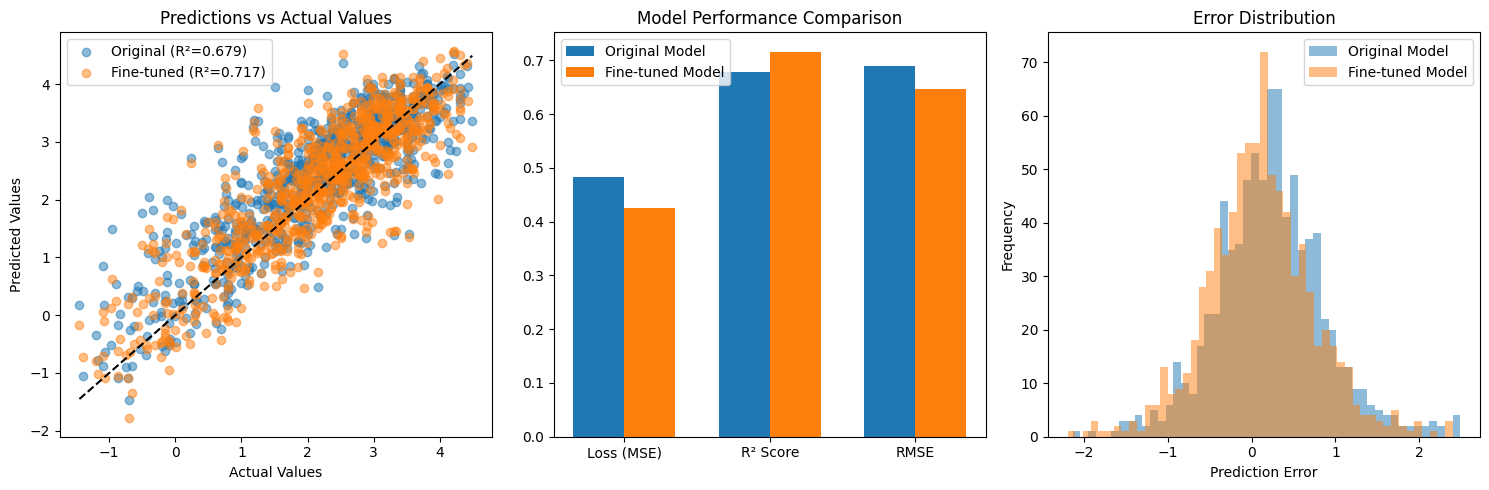


Model Improvements:
Loss Improvement (MSE): 0.0581
R² Score Improvement: 0.0379
RMSE Improvement: 0.0419

Original Model
Loss (MSE): 0.4833
R² Score: 0.6787
RMSE: 0.6890
------------------------------

Fine-Tuned Model :
Loss (MSE): 0.4252
R² Score: 0.7165
RMSE: 0.6471


In [25]:
import numpy as np
base_model = mlm_model.base_model if hasattr(mlm_model, 'base_model') else mlm_model

# Load both models and compare their performance
original_model = MoLFormerWithRegressionHead(AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)).to(device)
original_model.load_state_dict(torch.load("/content/regression_model.pth"))

fine_tuned_model = MoLFormerWithRegressionHead(AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)).to(device)
fine_tuned_model.load_state_dict(torch.load("/content/regression_model_final.pth"))

from sklearn.metrics import mean_squared_error, r2_score



# Evaluate both models
orig_loss, orig_r2, orig_rmse, orig_preds, orig_targets = evaluate_and_compare(original_model, test_loader, "Original Model")
ft_loss, ft_r2, ft_rmse, ft_preds, ft_targets = evaluate_and_compare(fine_tuned_model, test_loader, "Fine-tuned Model")

orig_metrics = [orig_loss, orig_r2, orig_rmse]
ft_metrics = [ft_loss, ft_r2, ft_rmse]

# Plot comparison with MSE included
plt.figure(figsize=(15, 5))

# Plot predictions vs actual
plt.subplot(1, 3, 1)
plt.scatter(orig_targets, orig_preds, alpha=0.5, label=f'Original (R²={orig_r2:.3f})')
plt.scatter(ft_targets, ft_preds, alpha=0.5, label=f'Fine-tuned (R²={ft_r2:.3f})')
plt.plot([min(orig_targets), max(orig_targets)], [min(orig_targets), max(orig_targets)], 'k--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.legend()

# Plot performance metrics
plt.subplot(1, 3, 2)
metrics = ['Loss (MSE)', 'R² Score', 'RMSE']
original_scores = [orig_loss, orig_r2, orig_rmse]
finetuned_scores = [ft_loss, ft_r2, ft_rmse]

x = range(len(metrics))
width = 0.35

plt.bar([i - width/2 for i in x], original_scores, width, label='Original Model')
plt.bar([i + width/2 for i in x], finetuned_scores, width, label='Fine-tuned Model')
plt.xticks(x, metrics)
plt.title('Model Performance Comparison')
plt.legend()

# Plot error distribution
plt.subplot(1, 3, 3)
orig_errors = np.array(orig_preds) - np.array(orig_targets)
ft_errors = np.array(ft_preds) - np.array(ft_targets)
plt.hist(orig_errors, bins=50, alpha=0.5, label='Original Model')
plt.hist(ft_errors, bins=50, alpha=0.5, label='Fine-tuned Model')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()

plt.tight_layout()
plt.show()

# # Print improvement metrics
print("\nModel Improvements:")
print(f"Loss Improvement (MSE): {orig_loss - ft_loss:.4f}")
print(f"R² Score Improvement: {ft_r2 - orig_r2:.4f}")
print(f"RMSE Improvement: {orig_rmse - ft_rmse:.4f}")

# Print metrics
print("\nOriginal Model")
print(f"Loss (MSE): {orig_loss:.4f}")
print(f"R² Score: {orig_r2:.4f}")
print(f"RMSE: {orig_rmse:.4f}")
print("-" * 30)
print("\nFine-Tuned Model :")
print(f"Loss (MSE): {ft_loss:.4f}")
print(f"R² Score: {ft_r2:.4f}")
print(f"RMSE: {ft_rmse:.4f}")

# Task 2

Now you understand how our model performs on Lipophilicity dataset through `Task1`. The goal in this task is to further enhance the performance by selecting external datapoints for training. You can use the [`task2.py`](../scripts/Task2.py) file for your implementation.


There is an external dataset (provided in the file [`External-Dataset_for_Task2.csv`](../tasks/External-Dataset_for_Task2.csv)) with molecular SMILES strings and corresponding lipophilicity values that we can include in the training process. However, we suspect that not all external data points are relevant. We aim to only select those that will likely improve the model's performance.  To achieve this, we will use **influence functions** to compute the impact of each external data point on the model’s behavior. This will help us identify the most valuable data points for training. By influence functions, we can analyze the distribution of influence scores and identify the high-impact samples (e.g., top-k positively scored samples). For influence computation, we refer to [Koh & Liang’s paper (2017)](https://arxiv.org/abs/1703.04730) on influence functions to calculate and log the influence scores for all samples in the external dataset.

The calculation of the influence function involves three main steps: computing the gradient of the training loss with respect to the model parameters, estimating the inverse of the Hessian matrix, and combining these to evaluate the effect of the training point on the test loss. The challenge for using it in deep neural networks is that storing and inverting the Hessian requires \( O(d^3) \) operations, where \( d \) is the number of model parameters, making it infeasible to compute for large neural networks. To address this, Koh & Liang (2017) proposed approximating the inverse Hessian-vector product (iHVP) using techniques like **Stochastic estimation/LiSSA** [(Agarwal et al., 2016)](https://arxiv.org/abs/1602.03943).

1. Your task is to compute the influence scores for each data point in the external dataset using the LiSSA approximation. This will help us identify which external samples are most influential in improving the model's performance. For this, you will:
- use the trained model and the external dataset.
- compute the gradients for each data point in the external dataset.
- use the LiSSA approximation to estimate the influence of each external sample on the model's performance on the test set.

2. Once the influence scores for the external dataset are computed, we can combine the high-impact samples selected with the Lipophilicity training dataset and fine-tune the model again. We can then evaluate the model’s performance on the Lipophilicity test set and compare it to the baseline in `Task1`.

### Task 2 - Part 1 - Computing Influence Scores

In [26]:
torch.cuda.empty_cache()

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_gradients(model, loss_fn, batch):
    """Compute gradients of loss w.r.t. model parameters."""
    model.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    target = batch['target'].to(device).unsqueeze(1)

    output = model(input_ids, attention_mask)
    loss = loss_fn(output, target)

    loss.backward()

    grads = [param.grad.view(-1) for param in model.parameters() if param.grad is not None]
    return torch.cat(grads) if grads else torch.zeros(1).to(device)

def lissa_inverse_hvp(model, loss_fn, v, train_loader, damping=0.01, scale=25.0, max_recursion_depth=80, epsilon=1e-5):
    """Compute inverse Hessian-vector product (iHVP) using adaptive recursion."""
    v = v.to(device)
    inverse_hvp = v.clone()

    # Select a subset of training data using loss-based sampling
    train_batches = list(train_loader)
    loss_values = []

    # Compute loss for each batch to select informative ones
    for batch in train_batches:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target = batch['target'].to(device).unsqueeze(1)

        with torch.no_grad():
            output = model(input_ids, attention_mask)
            loss = loss_fn(output, target)
            loss_values.append(loss.item())

    # Select top-k batches with highest loss
    sample_size = min(15, len(train_batches))  # Increase sample size for better accuracy
    top_batches = sorted(zip(loss_values, train_batches), key=lambda x: x[0], reverse=True)[:sample_size]
    selected_batches = [batch for _, batch in top_batches]

    prev_norm = float("inf")

    for i in range(max_recursion_depth):
        batch = selected_batches[i % len(selected_batches)]
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        target = batch['target'].to(device).unsqueeze(1)

        # Compute loss
        output = model(input_ids, attention_mask)
        loss = loss_fn(output, target)

        # Compute gradients
        grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grad_vector = torch.cat([g.view(-1) for g in grad_params])

        # Compute Hessian-vector product (HVP)
        hvp = torch.autograd.grad(grad_vector, model.parameters(), grad_outputs=inverse_hvp, retain_graph=True)
        hvp = torch.cat([g.view(-1) for g in hvp])

        # Update inverse Hessian-vector estimate
        inverse_hvp = v + (1 - damping) * inverse_hvp - scale * hvp

        # Gradient Clipping (stabilizes updates)
        torch.nn.utils.clip_grad_norm_(inverse_hvp, max_norm=10)

        # Adaptive stopping criterion
        norm_diff = torch.norm(inverse_hvp - prev_norm)
        if norm_diff < epsilon:
            break
        prev_norm = inverse_hvp.clone()

        torch.cuda.empty_cache()  # Free memory

    return inverse_hvp

def compute_influence_scores(model, loss_fn, train_loader, test_loader, damping=0.01, scale=25.0, max_recursion_depth=80):
    """Compute influence scores efficiently while maintaining accuracy."""
    test_grads = []
    for batch in tqdm(test_loader, desc="Computing Test Gradients"):
        test_grads.append(compute_gradients(model, loss_fn, batch))

    influence_scores = []
    for i, batch in enumerate(tqdm(test_loader, desc="Computing Influence Scores")):
        test_grad = test_grads[i]
        iHVP = lissa_inverse_hvp(model, loss_fn, test_grad, train_loader, damping, scale, max_recursion_depth)
        influence_score = torch.dot(test_grad, iHVP).item()
        influence_scores.append(influence_score)

        torch.cuda.empty_cache()  # Reduce memory usage

    return influence_scores

In [71]:
# Load external dataset
ext_data = pd.read_csv("/content/External-Dataset_for_Task2.csv")
ext_data = ext_data.rename(columns={"SMILES": "SMILES", "Label": "label"})

# Prepare DataLoader
ext_dataset = SMILESDataset(ext_data['SMILES'], ext_data['label'])
ext_loader = DataLoader(ext_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"External Dataset: {len(ext_loader)} batches")

External Dataset: 19 batches


In [ ]:


# Compute influence scores on external dataset with adaptive settings
ext_influence_scores = compute_influence_scores(
    regression_model, criterion, train_loader, ext_loader,
    damping=0.05, scale=25.0, max_recursion_depth=80
)

# Pick top 100 samples with highest influence scores
top_indices = np.argsort(ext_influence_scores)[-100:]
top_samples = ext_data.iloc[top_indices]

#save the top 100 samples with highest influence scores
top_samples.to_csv("top_influential_samples.csv", index=False)




Computing Test Gradients:   0%|          | 0/19 [00:00<?, ?it/s]

Computing Influence Scores:   0%|          | 0/19 [00:00<?, ?it/s]

In [28]:
# Combine the top 100 with training data

top_samples = pd.read_csv("/content/top_influential_samples.csv")
# Get the original training data as a DataFrame (assuming you still have access to it)
original_train_df = dataset['train'].to_pandas()  # or however you initially loaded the training data

# Now concatenate with top_samples
combined_data = pd.concat([original_train_df, top_samples], ignore_index=True)

# Prepare the combined dataset
combined_dataset = SMILESDataset(combined_data['SMILES'], combined_data['label'])
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Combined Dataset: {len(combined_loader)} batches")


Combined Dataset: 264 batches


### Task 2 - Part 2 - Evaluating Model on Dataset combined with Influential Points

Epoch 1/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 1/15 - Training MSE: 0.1775


Epoch 2/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 2/15 - Training MSE: 0.1521


Epoch 3/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 3/15 - Training MSE: 0.1449


Epoch 4/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 4/15 - Training MSE: 0.1380


Epoch 5/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 5/15 - Training MSE: 0.1246


Epoch 6/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 6/15 - Training MSE: 0.1198


Epoch 7/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 7/15 - Training MSE: 0.1085


Epoch 8/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 8/15 - Training MSE: 0.1139


Epoch 9/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 9/15 - Training MSE: 0.1028


Epoch 10/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 10/15 - Training MSE: 0.1023


Epoch 11/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 11/15 - Training MSE: 0.0933


Epoch 12/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 12/15 - Training MSE: 0.0945


Epoch 13/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 13/15 - Training MSE: 0.0942


Epoch 14/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 14/15 - Training MSE: 0.0889


Epoch 15/15:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 15/15 - Training MSE: 0.0852

Final Results:
Test Loss (MSE): 0.0803
R² Score: 0.9454
RMSE: 0.2839


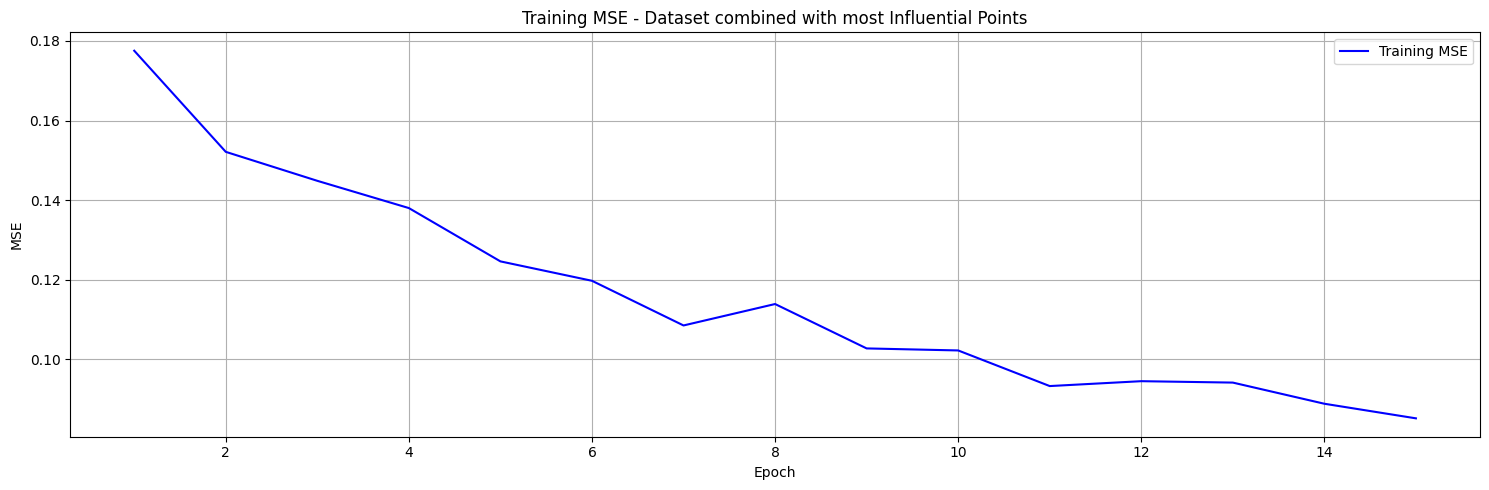

In [29]:
# Fine-tune the model on the combined dataset
base_model = mlm_model.base_model if hasattr(mlm_model, 'base_model') else mlm_model


#Load the final_regression_model.pth
regression_model = MoLFormerWithRegressionHead(base_model).to(device)
regression_model.load_state_dict(torch.load('/content/regression_model_final.pth'))
# Specify optimizer, scheduler and loss function
optimizer = torch.optim.AdamW(regression_model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.MSELoss()

train_mse_history = []

# evaluate model already defined
# Fine-tune the model on the regression task
epochs = 15

try:
    for epoch in range(epochs):
        regression_model.train()
        total_loss = 0
        progress_bar = tqdm(combined_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            logits = regression_model(input_ids, attention_mask)
            loss = criterion(logits.squeeze(), targets)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(regression_model.parameters(), max_norm=1.0)

            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        training_mse = total_loss / len(combined_loader)
        train_mse_history.append(training_mse)
        print(f"Epoch {epoch+1}/{epochs} - Training MSE: {training_mse:.4f}")

        # Optionally, update the learning rate scheduler based on training loss
        scheduler.step(training_mse)

    # Evaluate on test set only once after all epochs
    final_loss, final_r2, final_rmse = evaluate_model(regression_model, test_loader, criterion)
    print(f"\nFinal Results:")
    print(f"Test Loss (MSE): {final_loss:.4f}")
    print(f"R² Score: {final_r2:.4f}")
    print(f"RMSE: {final_rmse:.4f}")

    # Save the new model for future use
    torch.save(regression_model.state_dict(), "regression_model_final_influence.pth")

    # Visualization
    plt.figure(figsize=(15, 5))
    # Plot training MSE over epochs
    plt.plot(range(1, epochs + 1), train_mse_history, 'b-', label='Training MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Training MSE - Dataset combined with most Influential Points')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during training: {str(e)}")



Model before fine-tuning on Influential Data Results:
Test Loss (MSE): 0.0898
R² Score: 0.9396
MSE: 0.0892

Model After Fine-Tuning on Influential Data Results:
Test Loss (MSE): 0.0771
R² Score: 0.9476
MSE: 0.0774

Model Improvements:
Loss Improvement (MSE): 0.0127
R² Score Improvement: 0.0080
RMSE Improvement: 0.0205


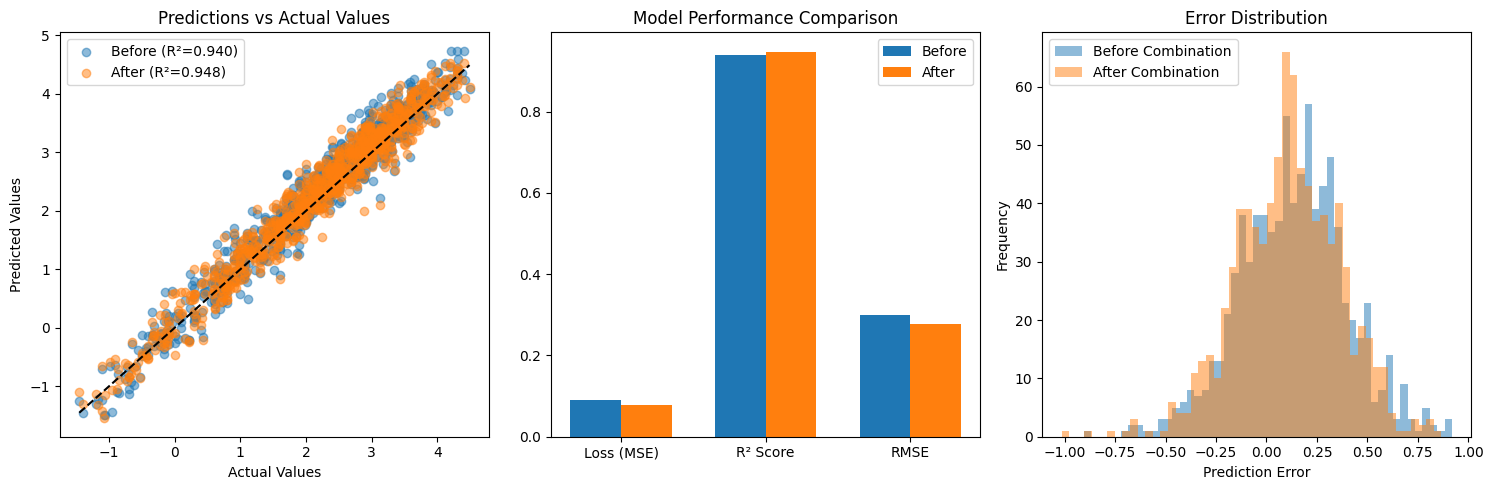

In [87]:
#compare the performance of the fine-tuned model on the test_df set before and after adding the external data
# Load the model before adding external data

base_model = mlm_model.base_model if hasattr(mlm_model, 'base_model') else mlm_model

regression_model_before = MoLFormerWithRegressionHead(base_model).to(device)
regression_model_before.load_state_dict(torch.load("/content/regression_model_final.pth"))
# Load the model after adding external data
regression_model_after = MoLFormerWithRegressionHead(base_model).to(device)
regression_model_after.load_state_dict(torch.load("/content/regression_model_final_influence.pth"))

# Evaluate both models

# Evaluate the model before adding external data
before_loss, before_r2, before_rmse, before_preds, before_targets = evaluate_and_compare(regression_model_before, test_loader, "Model before fine-tuning on Influential Data")

# Evaluate the model after adding external data
after_loss, after_r2, after_rmse, after_preds, after_targets = evaluate_and_compare(regression_model_after, test_loader, "Model After Fine-Tuning on Influential Data")

# save the model
#torch.save(regression_model_after.state_dict(), "regression_model_final_influence.pth")

influence_comb_scores = [after_loss, after_r2, after_rmse]
metrics_before = [before_loss, before_r2, before_rmse]

# # Print improvement metrics
print("\nModel Improvements:")
print(f"Loss Improvement (MSE): {before_loss - after_loss:.4f}")
print(f"R² Score Improvement: {after_r2 - before_r2:.4f}")
print(f"RMSE Improvement: {before_rmse - after_rmse:.4f}")


# Plot comparison with MSE included
plt.figure(figsize=(15, 5))

# Plot predictions vs actual
plt.subplot(1, 3, 1)
plt.scatter(before_targets, before_preds, alpha=0.5, label=f'Before (R²={before_r2:.3f})')
plt.scatter(after_targets, after_preds, alpha=0.5, label=f'After (R²={after_r2:.3f})')
plt.plot([min(before_targets), max(before_targets)], [min(before_targets), max(before_targets)], 'k--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.legend()

# Plot performance metrics
plt.subplot(1, 3, 2)
metrics = ['Loss (MSE)', 'R² Score', 'RMSE']
before_comb_scores = [before_loss, before_r2, before_rmse]
after_comb_scores = [after_loss, after_r2, after_rmse]

x = range(len(metrics))
width = 0.35

plt.bar([i - width/2 for i in x], before_comb_scores, width, label='Before')
plt.bar([i + width/2 for i in x], after_comb_scores, width, label='After')
plt.xticks(x, metrics)
plt.title('Model Performance Comparison')
plt.legend()

# Plot error distribution
plt.subplot(1, 3, 3)
before_errors = np.array(before_preds) - np.array(before_targets)
after_errors = np.array(after_preds) - np.array(after_targets)
plt.hist(before_errors, bins=50, alpha=0.5, label='Before Combination')
plt.hist(after_errors, bins=50, alpha=0.5, label='After Combination')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()

plt.tight_layout()
plt.show()






# Task 3: Exploration of Data Selection and Fine-Tuning Methods

In this task, you can explore alternative methods for data selection and investigate several fine-tuning techniques to adapt a pre-trained model for a specific task. The goal is to improve the model performance on our target dataset. You can use the [`task3.py`](../scripts/Task3.py) file for your implementation.

1. Data Selection Strategies
The first step in fine-tuning a model is to carefully select the training data. While the previous tasks focused on influence-based data selection, here you will experiment with other selection strategies. Pick one data selection method by yourself. Log your findings about the selected data subsets:
    - How much data is used in each strategy?
    - Compare the performance of models trained with each selection method.

2. Fine-tuning Strategies
In this section, you will implement and compare some parameter-efficient fine-tuning approaches:

    - [bitfit](https://arxiv.org/abs/2106.10199)
    - [LoRA](https://arxiv.org/abs/2106.09685) (Low-Rank Adaptation)
    - iA3 (see Section 3.3. of this [paper](https://arxiv.org/abs/2205.05638)) (Implicit Adapter)

### Task 3 - Part 1 - Data Selection Strategies

In [68]:
from sklearn.cluster import KMeans

In [ ]:
# load the final model

base_model = mlm_model.base_model if hasattr(mlm_model, 'base_model') else mlm_model

regression_model = MoLFormerWithRegressionHead(base_model).to(device)
regression_model.load_state_dict(torch.load('/content/regression_model_final.pth'))

<All keys matched successfully>

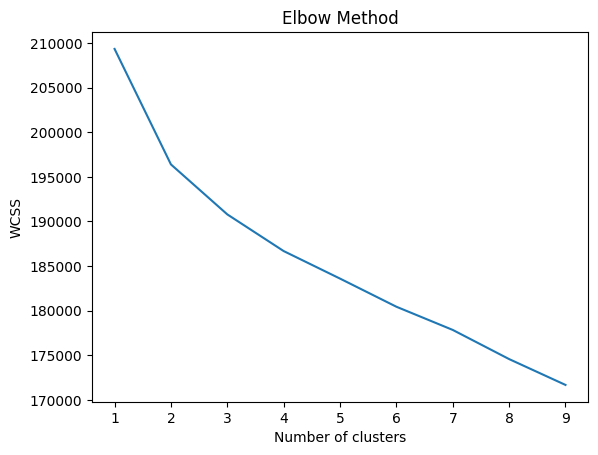

In [73]:
# find optimal number of clusters using the elbow method
embeddings = []
for smiles in ext_data['SMILES']:
    inputs = tokenizer(smiles, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
    embeddings.append(inputs['input_ids'].squeeze().numpy())  # Get input ids (can change based on model)
# Convert to a numpy array for clustering after accumulating all embeddings
embeddings = np.array(embeddings)

wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [74]:
# Function for diversity sampling based on k-means clustering
def diversity_sampling(data, tokenizer, n_clusters=5, sample_size=100):
    # Tokenize the data
    embeddings = []
    for smiles in data['SMILES']:
        inputs = tokenizer(smiles, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
        embeddings.append(inputs['input_ids'].squeeze().numpy())  # Get input ids (can change based on model)

    # Convert to a numpy array for clustering
    embeddings = np.array(embeddings)

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(embeddings)

    # Get the closest point to the center of each cluster
    closest_points = []
    for i in range(n_clusters):
        cluster_points = np.where(kmeans.labels_ == i)[0]
        distances = np.linalg.norm(embeddings[cluster_points] - kmeans.cluster_centers_[i], axis=1)
        closest_point = cluster_points[np.argmin(distances)]
        closest_points.append(closest_point)

    # Select the top sample_size number of diverse samples
    diverse_samples = data.iloc[closest_points]

    # If more samples are needed, randomly select from other data points in the same cluster
    if len(diverse_samples) < sample_size:
        remaining_samples = data[~data.index.isin(diverse_samples.index)]
        remaining_samples = remaining_samples.sample(n=sample_size - len(diverse_samples), random_state=42)
        diverse_samples = pd.concat([diverse_samples, remaining_samples])

    return diverse_samples





diverse_sample = diversity_sampling(ext_data, tokenizer, n_clusters=2, sample_size=100)
print(f"Selected {len(diverse_sample)} diverse samples.")

Selected 100 diverse samples.


In [75]:
# Number of samples for training
n_samples = 100

# 1. Random Sampling: Randomly select 100 points from combined_data for training
random_sample = ext_data.sample(n=n_samples, random_state=42)
print(f"Selected {len(random_sample)} random samples.")

Selected 100 random samples.


In [76]:
# 2. Uncertainity based Sampling: Select 100 points with highest entropy from the external dataset
# Calculate entropy for each sample
entropy_scores = []
for smiles in ext_data['SMILES']:
    inputs = tokenizer(smiles, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
    logits = regression_model(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    entropy = -np.sum(probs * np.log(probs + 1e-6))
    entropy_scores.append(entropy)

# Select top 100 samples with highest entropy
entropy_df = ext_data.copy()
entropy_df['entropy'] = entropy_scores
entropy_sample = entropy_df.nlargest(n_samples, 'entropy')
 #drop the entropy column
entropy_sample = entropy_sample.drop(columns=['entropy'])
print(f"Selected {len(entropy_sample)} samples with highest entropy.")

Selected 100 samples with highest entropy.


In [77]:


# Combine random samples with original training dataset
random_training = pd.concat([original_train_df, random_sample], ignore_index=True)
entropy_training = pd.concat([original_train_df, entropy_sample], ignore_index=True)
diverse_training = pd.concat([original_train_df, diverse_sample], ignore_index=True)

# Prepare the combined dataset using SMILESDataset
random_dataset = SMILESDataset(random_training['SMILES'], random_training['label'])
entropy_dataset = SMILESDataset(entropy_training['SMILES'], entropy_training['label'])
diverse_dataset = SMILESDataset(diverse_training['SMILES'], diverse_training['label'])

# Create DataLoaders from the datasets for training
random_loader = DataLoader(random_dataset, batch_size=BATCH_SIZE, shuffle=True)
entropy_loader = DataLoader(entropy_dataset, batch_size=BATCH_SIZE, shuffle=True)
diverse_loader = DataLoader(diverse_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Random Sampling: {len(random_loader)} batches")
print(f"Uncertainity Sampling: {len(entropy_loader)} batches")
print(f"Diversity Sampling: {len(diverse_loader)} batches")

Random Sampling: 269 batches
Uncertainity Sampling: 269 batches
Diversity Sampling: 269 batches


Epoch 1/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 1/15 - Training MSE: 0.1892


Epoch 2/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 2/15 - Training MSE: 0.1906


Epoch 3/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 3/15 - Training MSE: 0.1875


Epoch 4/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 4/15 - Training MSE: 0.1840


Epoch 5/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 5/15 - Training MSE: 0.1862


Epoch 6/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 6/15 - Training MSE: 0.1867


Epoch 7/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 7/15 - Training MSE: 0.1819


Epoch 8/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 8/15 - Training MSE: 0.1773


Epoch 9/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 9/15 - Training MSE: 0.1771


Epoch 10/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 10/15 - Training MSE: 0.1756


Epoch 11/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 11/15 - Training MSE: 0.1835


Epoch 12/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 12/15 - Training MSE: 0.1764


Epoch 13/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 13/15 - Training MSE: 0.1802


Epoch 14/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 14/15 - Training MSE: 0.1827


Epoch 15/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 15/15 - Training MSE: 0.1791

Final Results:
Test Loss (MSE): 0.4115
R² Score: 0.7274
RMSE: 0.6347


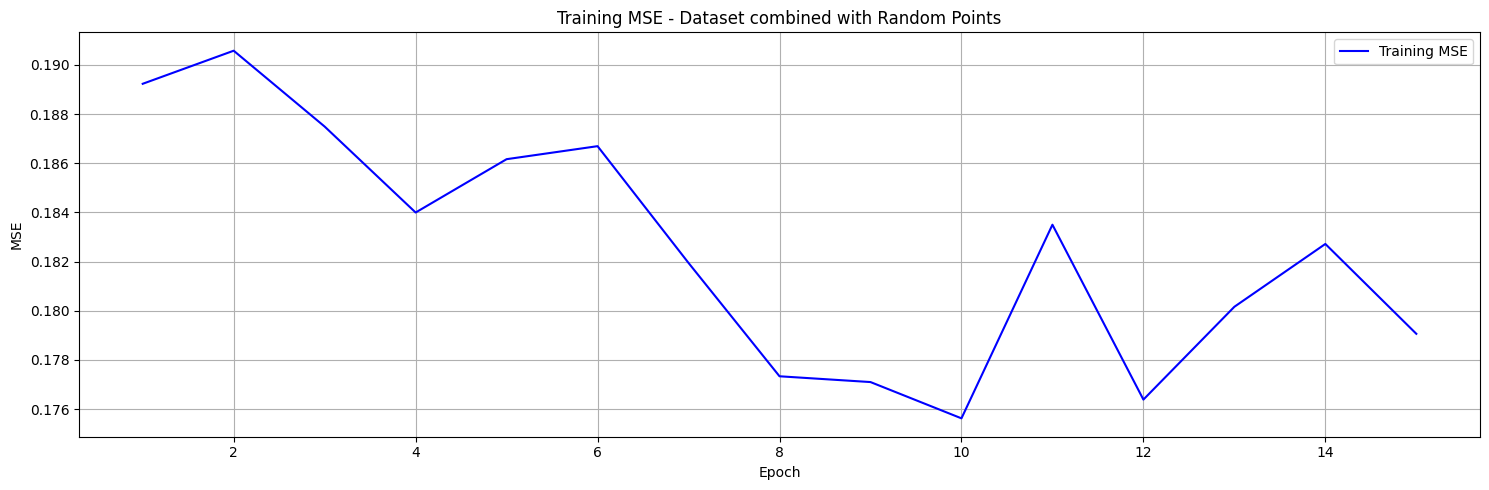

In [81]:
# Fine-tune the model on the random dataset

#Load the final_regression_model.pth
regression_model = MoLFormerWithRegressionHead(base_model).to(device)
regression_model.load_state_dict(torch.load('/content/regression_model_final.pth'))
# Specify optimizer, scheduler and loss function
optimizer = torch.optim.AdamW(regression_model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.MSELoss()

train_mse_history = []

# evaluate model already defined
# Fine-tune the model on the regression task
epochs = 15

try:
    for epoch in range(epochs):
        regression_model.train()
        total_loss = 0
        progress_bar = tqdm(random_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            logits = regression_model(input_ids, attention_mask)
            loss = criterion(logits.squeeze(), targets)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(regression_model.parameters(), max_norm=1.0)

            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        training_mse = total_loss / len(random_loader)
        train_mse_history.append(training_mse)
        print(f"Epoch {epoch+1}/{epochs} - Training MSE: {training_mse:.4f}")

        # Optionally, update the learning rate scheduler based on training loss
        scheduler.step(training_mse)

    # Evaluate on test set only once after all epochs
    final_loss, final_r2, final_rmse = evaluate_model(regression_model, test_loader, criterion)
    print(f"\nFinal Results:")
    print(f"Test Loss (MSE): {final_loss:.4f}")
    print(f"R² Score: {final_r2:.4f}")
    print(f"RMSE: {final_rmse:.4f}")

    random_loss=final_loss
    random_r2=final_r2
    random_rmse=final_rmse

    # Save the new model for future use
    torch.save(regression_model.state_dict(), "regression_model_final_random.pth")

    # Visualization
    plt.figure(figsize=(15, 5))
    # Plot training MSE over epochs
    plt.plot(range(1, epochs + 1), train_mse_history, 'b-', label='Training MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Training MSE - Dataset combined with Random Points')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during training: {str(e)}")


Epoch 1/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 1/15 - Training MSE: 0.1976


Epoch 2/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 2/15 - Training MSE: 0.2049


Epoch 3/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 3/15 - Training MSE: 0.2001


Epoch 4/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 4/15 - Training MSE: 0.2012


Epoch 5/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 5/15 - Training MSE: 0.1957


Epoch 6/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 6/15 - Training MSE: 0.1972


Epoch 7/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 7/15 - Training MSE: 0.2002


Epoch 8/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 8/15 - Training MSE: 0.1979


Epoch 9/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 9/15 - Training MSE: 0.1998


Epoch 10/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 10/15 - Training MSE: 0.1913


Epoch 11/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 11/15 - Training MSE: 0.1994


Epoch 12/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 12/15 - Training MSE: 0.1966


Epoch 13/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 13/15 - Training MSE: 0.2018


Epoch 14/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 14/15 - Training MSE: 0.1945


Epoch 15/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 15/15 - Training MSE: 0.1948

Final Results:
Test Loss (MSE): 0.4225
R² Score: 0.7184
RMSE: 0.6451


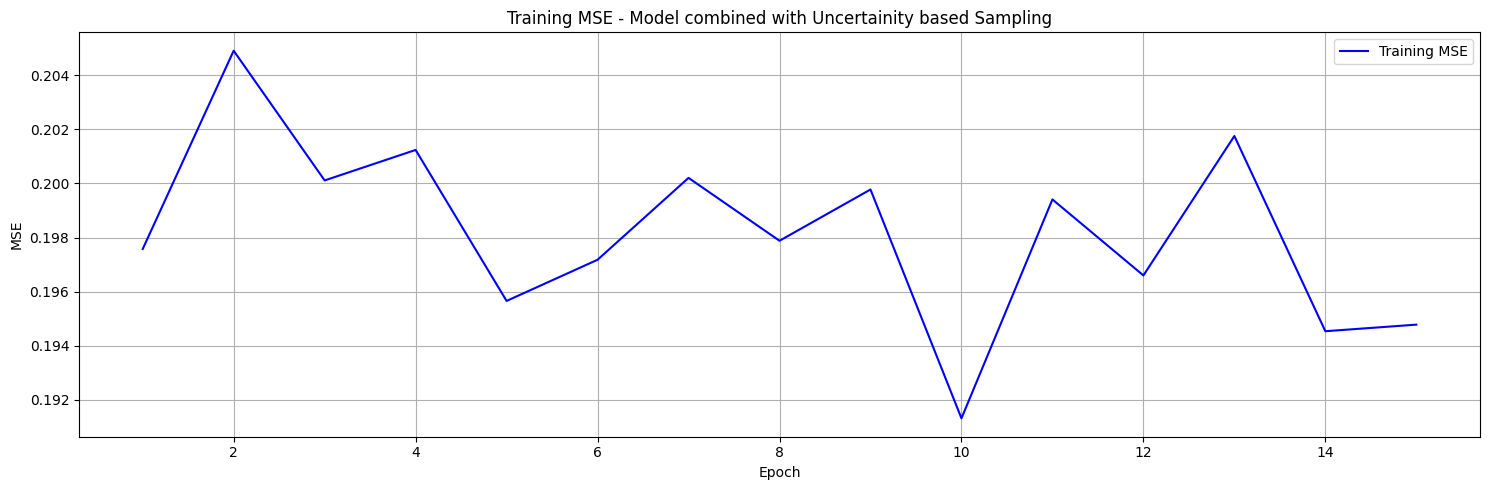

In [82]:
# fine tune the model on entropy set
# Load the final_regression_model.pth
regression_model = MoLFormerWithRegressionHead(base_model).to(device)
regression_model.load_state_dict(torch.load('/content/regression_model_final.pth'))

# Fine-tune the model on the regression task
epochs = 15

# Reinitialize training MSE history
train_mse_history = []

try:
    for epoch in range(epochs):
        regression_model.train()
        total_loss = 0
        progress_bar = tqdm(entropy_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            logits = regression_model(input_ids, attention_mask)
            loss = criterion(logits.squeeze(), targets)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(regression_model.parameters(), max_norm=1.0)

            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        training_mse = total_loss / len(entropy_loader)
        train_mse_history.append(training_mse)
        print(f"Epoch {epoch+1}/{epochs} - Training MSE: {training_mse:.4f}")

        # Optionally, update the learning rate scheduler based on training loss
        scheduler.step(training_mse)

    # Evaluate on test set only once after all epochs
    final_loss, final_r2, final_rmse = evaluate_model(regression_model, test_loader, criterion)
    print(f"\nFinal Results:")
    print(f"Test Loss (MSE): {final_loss:.4f}")
    print(f"R² Score: {final_r2:.4f}")
    print(f"RMSE: {final_rmse:.4f}")
    entropy_loss=final_loss
    entropy_r2=final_r2
    entropy_rmse=final_rmse

    # Save the new model for future use
    torch.save(regression_model.state_dict(), "regression_model_final_entropy.pth")

    # Visualization
    plt.figure(figsize=(15, 5))
    # Plot training MSE over epochs
    plt.plot(range(1, len(train_mse_history) + 1), train_mse_history, 'b-', label='Training MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Training MSE - Model combined with Uncertainity based Sampling')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during training: {str(e)}")

Epoch 1/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 1/15 - Training MSE: 0.1879


Epoch 2/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 2/15 - Training MSE: 0.1876


Epoch 3/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 3/15 - Training MSE: 0.1879


Epoch 4/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 4/15 - Training MSE: 0.1886


Epoch 5/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 5/15 - Training MSE: 0.1866


Epoch 6/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 6/15 - Training MSE: 0.1898


Epoch 7/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 7/15 - Training MSE: 0.1898


Epoch 8/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 8/15 - Training MSE: 0.1909


Epoch 9/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 9/15 - Training MSE: 0.1919


Epoch 10/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 10/15 - Training MSE: 0.1946


Epoch 11/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 11/15 - Training MSE: 0.1896


Epoch 12/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 12/15 - Training MSE: 0.1847


Epoch 13/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 13/15 - Training MSE: 0.1878


Epoch 14/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 14/15 - Training MSE: 0.1898


Epoch 15/15:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch 15/15 - Training MSE: 0.1868

Final Results:
Test Loss (MSE): 0.4265
R² Score: 0.7161
RMSE: 0.6477


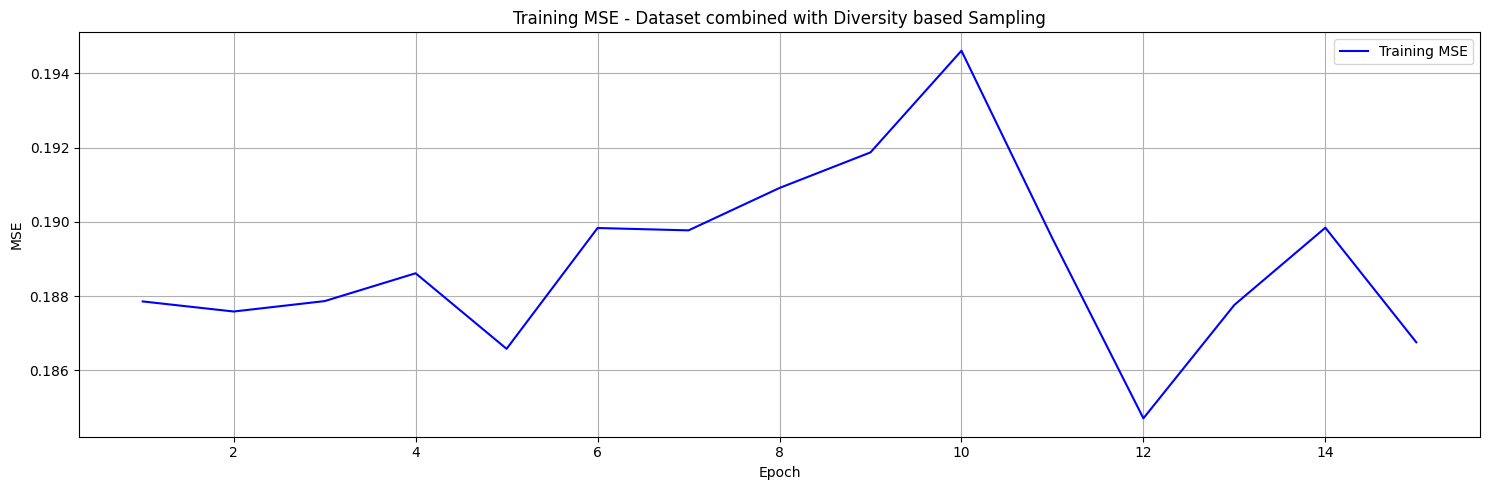

In [83]:
# fine tune the model on diverse set
# Load the final_regression_model.pth
regression_model = MoLFormerWithRegressionHead(base_model).to(device)
regression_model.load_state_dict(torch.load('/content/regression_model_final.pth'))

# Fine-tune the model on the regression task
epochs = 15

# Reinitialize training MSE history
train_mse_history = []

try:
    for epoch in range(epochs):
        regression_model.train()
        total_loss = 0
        progress_bar = tqdm(diverse_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            logits = regression_model(input_ids, attention_mask)
            loss = criterion(logits.squeeze(), targets)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(regression_model.parameters(), max_norm=1.0)

            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        training_mse = total_loss / len(diverse_loader)
        train_mse_history.append(training_mse)
        print(f"Epoch {epoch+1}/{epochs} - Training MSE: {training_mse:.4f}")

        # Optionally, update the learning rate scheduler based on training loss
        scheduler.step(training_mse)

    # Evaluate on test set only once after all epochs
    final_loss, final_r2, final_rmse = evaluate_model(regression_model, test_loader, criterion)
    print(f"\nFinal Results:")
    print(f"Test Loss (MSE): {final_loss:.4f}")
    print(f"R² Score: {final_r2:.4f}")
    print(f"RMSE: {final_rmse:.4f}")
    diverse_loss=final_loss
    diverse_r2=final_r2
    diverse_rmse=final_rmse

    # Save the new model for future use
    torch.save(regression_model.state_dict(), "regression_model_final_diverse.pth")

    # Visualization
    plt.figure(figsize=(15, 5))
    # Plot training MSE over epochs
    plt.plot(range(1, len(train_mse_history) + 1), train_mse_history, 'b-', label='Training MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Training MSE - Dataset combined with Diversity based Sampling')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred during training: {str(e)}")


Random Sampling Results:
Test Loss (MSE): 0.4057
R² Score: 0.7279
MSE: 0.4020

Uncertainity Sampling Results:
Test Loss (MSE): 0.4181
R² Score: 0.7213
MSE: 0.4118

Diverse Sampling Results:
Test Loss (MSE): 0.4372
R² Score: 0.7097
MSE: 0.4288


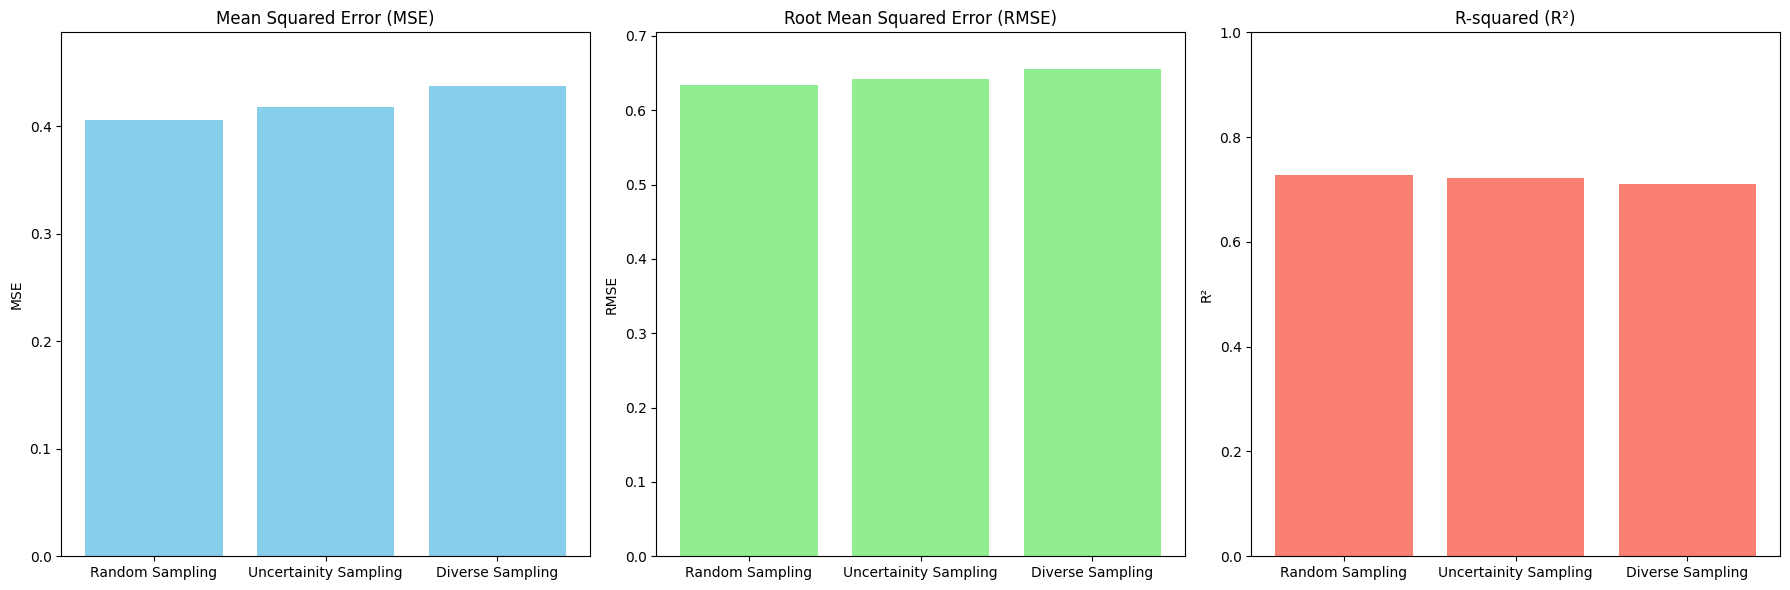

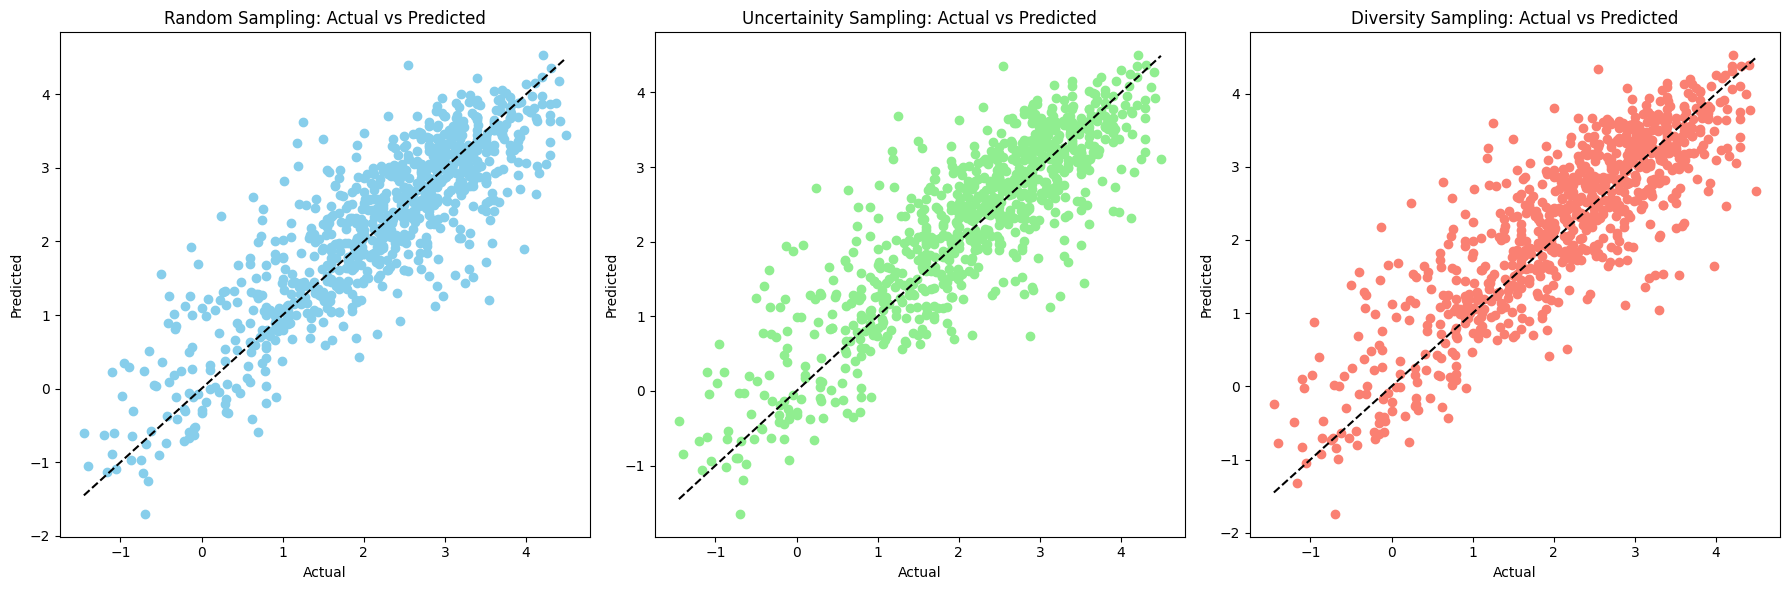

In [84]:
# load the 3 regression models
regression_model_random = MoLFormerWithRegressionHead(base_model).to(device)
regression_model_random.load_state_dict(torch.load('/content/regression_model_final_random.pth'))

regression_model_entropy = MoLFormerWithRegressionHead(base_model).to(device)
regression_model_entropy.load_state_dict(torch.load('/content/regression_model_final_entropy.pth'))

regression_model_diverse = MoLFormerWithRegressionHead(base_model).to(device)
regression_model_diverse.load_state_dict(torch.load('/content/regression_model_final_diverse.pth'))

# Evaluate and compare the 3 models
random_loss, random_r2, random_rmse, random_preds, random_targets = evaluate_and_compare(regression_model_random, test_loader, "Random Sampling")
entropy_loss, entropy_r2, entropy_rmse, entropy_preds, entropy_targets = evaluate_and_compare(regression_model_entropy, test_loader, "Uncertainity Sampling")
diverse_loss, diverse_r2, diverse_rmse, diverse_preds, diverse_targets = evaluate_and_compare(regression_model_diverse, test_loader, "Diverse Sampling")

models=['Random Sampling', 'Uncertainity Sampling', 'Diverse Sampling']

mse_values = [random_loss, entropy_loss, diverse_loss]
rmse_values = [random_rmse, entropy_rmse, diverse_rmse]
r2_values = [random_r2, entropy_r2, diverse_r2]

random_metrics = [random_loss, random_rmse, random_r2]
entropy_metrics = [entropy_loss, entropy_rmse, entropy_r2]
diverse_metrics = [diverse_loss, diverse_rmse, diverse_r2]

# Set up the figure and axes for the bar plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot MSE
axes[0].bar(models, mse_values, color='skyblue')
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_ylabel('MSE')
axes[0].set_ylim(0, max(mse_values) + 0.05)

# Plot RMSE
axes[1].bar(models, rmse_values, color='lightgreen')
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].set_ylabel('RMSE')
axes[1].set_ylim(0, max(rmse_values) + 0.05)

# Plot R²
axes[2].bar(models, r2_values, color='salmon')
axes[2].set_title('R-squared (R²)')
axes[2].set_ylabel('R²')
axes[2].set_ylim(0, 1)

# Adjust layout
plt.tight_layout()
plt.show()

# Scatter plot of actual vs predicted values for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter for Random Sampling model
axes[0].scatter(random_targets, random_preds, color='skyblue')
axes[0].plot([min(random_targets), max(random_targets)], [min(random_targets), max(random_targets)], color='black', linestyle='--')
axes[0].set_title('Random Sampling: Actual vs Predicted')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Scatter for Uncertainity based Sampling model
axes[1].scatter(entropy_targets, entropy_preds, color='lightgreen')
axes[1].plot([min(entropy_targets), max(entropy_targets)], [min(entropy_targets), max(entropy_targets)], color='black', linestyle='--')
axes[1].set_title('Uncertainity Sampling: Actual vs Predicted')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Scatter for Diversity Sampling model
axes[2].scatter(diverse_targets, diverse_preds, color='salmon')
axes[2].plot([min(diverse_targets), max(diverse_targets)], [min(diverse_targets), max(diverse_targets)], color='black', linestyle='--')
axes[2].set_title('Diversity Sampling: Actual vs Predicted')
axes[2].set_xlabel('Actual')
axes[2].set_ylabel('Predicted')

# Adjust layout
plt.tight_layout()
plt.show()


### Task 3 - Part 2 - Fine Tuning Strategies

In [31]:
import torch.nn as nn

class LoRALayer(nn.Module):
    def __init__(self, original_layer, lora_A, lora_B):
        super().__init__()
        self.original_layer = original_layer
        self.lora_A = lora_A
        self.lora_B = lora_B
        self.scale = nn.Parameter(torch.ones(1))

    def forward(self, x):
        return self.original_layer(x) + self.scale * self.lora_B(self.lora_A(x))


class LoRA(nn.Module):
    def __init__(self, base_model, rank=8):
        super().__init__()
        self.base_model = base_model
        self.lora_layers = ["layers.0.attention.self.query", "layers.0.attention.self.key", "layers.0.attention.self.value"]
        self._inject_lora_layers(rank)

    def _inject_lora_layers(self, rank):
        for name, module in list(self.base_model.named_modules()):
            if isinstance(module, nn.Linear) and name in self.lora_layers:
                lora_A = nn.Linear(module.in_features, rank, bias=False)
                lora_B = nn.Linear(rank, module.out_features, bias=False)
                nn.init.kaiming_uniform_(lora_A.weight, a=torch.sqrt(torch.tensor(5.0)))
                nn.init.zeros_(lora_B.weight)
                setattr(self.base_model, name, LoRALayer(module, lora_A, lora_B))

    def forward(self, input_ids, attention_mask):
        return self.base_model(input_ids=input_ids, attention_mask=attention_mask)


class IA3Layer(nn.Module):
    def __init__(self, original_layer):
        super().__init__()
        self.original_layer = original_layer
        self.scale = nn.Parameter(torch.ones(1))

    def forward(self, x):
        return self.scale * self.original_layer(x)


class IA3(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.ia3_layers = ["layers.0.attention.self.query", "layers.0.attention.self.key", "layers.0.attention.self.value"]
        self._inject_ia3_layers()

    def _inject_ia3_layers(self):
        for name, module in list(self.base_model.named_modules()):
            if isinstance(module, nn.Linear) and name in self.ia3_layers:
                setattr(self.base_model, name, IA3Layer(module))

    def forward(self, input_ids, attention_mask):
        return self.base_model(input_ids=input_ids, attention_mask=attention_mask)


class BitFit(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self._freeze_model_parameters()
        self._identify_bias_parameters()

    def _freeze_model_parameters(self):
        for name, param in self.base_model.named_parameters():
            if "bias" not in name:
                param.requires_grad = False

    def _identify_bias_parameters(self):
        self.bias_params = nn.ParameterList()
        for name, module in self.base_model.named_modules():
            if isinstance(module, (nn.Linear, nn.LayerNorm)) and module.bias is not None:
                self.bias_params.append(module.bias)

    def forward(self, input_ids, attention_mask):
        return self.base_model(input_ids=input_ids, attention_mask=attention_mask)



Epoch 1/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.0865


Epoch 2/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.0820


Epoch 3/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.0800


Epoch 4/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.0773


Epoch 5/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.0738


Epoch 6/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.0755


Epoch 7/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.0720


Epoch 8/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.0708


Epoch 9/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.0678


Epoch 10/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.0633


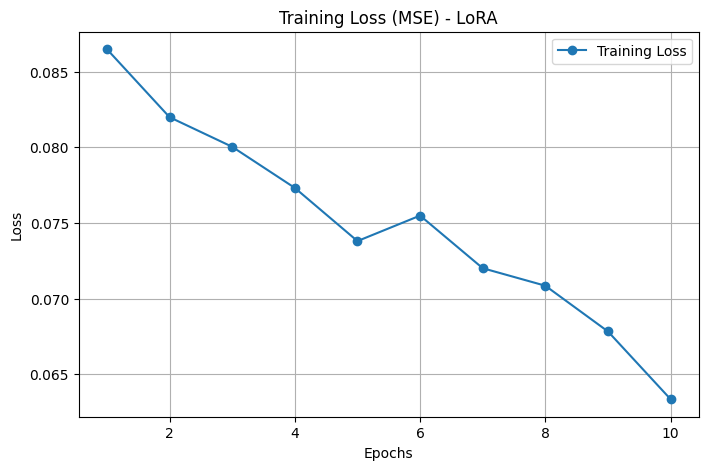

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = mlm_model.base_model if hasattr(mlm_model, 'base_model') else mlm_model

# Load Base Model
regression_model = MoLFormerWithRegressionHead(base_model).to(device)
regression_model.load_state_dict(torch.load('/content/regression_model_final_influence.pth'))
lora_model = LoRA(regression_model, rank=8).to(device)

# Optimizer, Scheduler, and Loss Function
optimizer = torch.optim.AdamW(lora_model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.MSELoss()

# Training Loop
epochs = 10
train_loss_history = []
for epoch in range(epochs):
    lora_model.train()
    total_loss = 0
    progress_bar = tqdm(combined_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            outputs = lora_model(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(lora_model.parameters(), max_norm=1.0)  # Prevent exploding gradients
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    train_loss = total_loss / len(combined_loader)
    train_loss_history.append(train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")
    scheduler.step(train_loss)  # Adjust learning rate based on loss



# Save Model
torch.save(lora_model.state_dict(), "lora_model_final.pth")

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss (MSE) - LoRA')
plt.legend()
plt.grid()
plt.show()




Epoch 1/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.0819


Epoch 2/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.0827


Epoch 3/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.0801


Epoch 4/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.0778


Epoch 5/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.0771


Epoch 6/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.0715


Epoch 7/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.0719


Epoch 8/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.0673


Epoch 9/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.0687


Epoch 10/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.0679


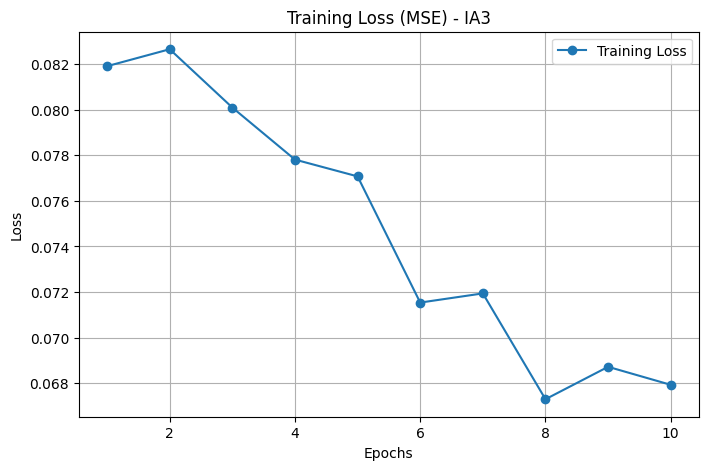

In [36]:
base_model = mlm_model.base_model if hasattr(mlm_model, 'base_model') else mlm_model

# Load Base Model
regression_model = MoLFormerWithRegressionHead(base_model).to(device)
regression_model.load_state_dict(torch.load('/content/regression_model_final_influence.pth'))
ia3_model = IA3(regression_model).to(device)

optimizer = torch.optim.AdamW(ia3_model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

train_loss_history = []
for epoch in range(epochs):
    ia3_model.train()
    total_loss = 0
    progress_bar = tqdm(combined_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)


        optimizer.zero_grad()
        outputs = ia3_model(input_ids, attention_mask)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ia3_model.parameters(), max_norm=1.0)  # Prevent exploding gradients
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    train_loss = total_loss / len(combined_loader)
    train_loss_history.append(train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")
    scheduler.step(train_loss)  # Adjust learning rate based on loss

torch.save(ia3_model.state_dict(), "ia3_model_final.pth")

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss (MSE) - IA3')
plt.legend()
plt.grid()
plt.show()



Epoch 1/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.0906


Epoch 2/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.0854


Epoch 3/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.0820


Epoch 4/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.0905


Epoch 5/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.0837


Epoch 6/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.0909


Epoch 7/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.0807


Epoch 8/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.0791


Epoch 9/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.0787


Epoch 10/10:   0%|          | 0/264 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.0838


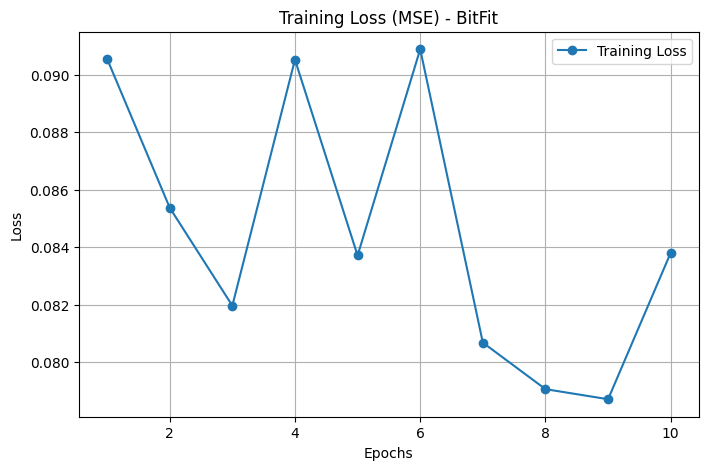

In [37]:
base_model = mlm_model.base_model if hasattr(mlm_model, 'base_model') else mlm_model

# Load Base Model
regression_model = MoLFormerWithRegressionHead(base_model).to(device)
regression_model.load_state_dict(torch.load('/content/regression_model_final_influence.pth'))
bitfit_model = BitFit(regression_model).to(device)

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, bitfit_model.parameters()), lr=1e-3)

train_loss_history = []
for epoch in range(epochs):
    bitfit_model.train()
    total_loss = 0
    progress_bar = tqdm(combined_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        optimizer.zero_grad()
        outputs = bitfit_model(input_ids, attention_mask)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bitfit_model.parameters(), max_norm=1.0)  # Prevent exploding gradients
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")


    train_loss = total_loss / len(combined_loader)
    train_loss_history.append(train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")
    scheduler.step(train_loss)  # Adjust learning rate based on loss

torch.save(bitfit_model.state_dict(), "bitfit_model_final.pth")

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss_history, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training Loss (MSE) - BitFit')
plt.legend()
plt.grid()
plt.show()



In [38]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters in LoRA Model: {count_trainable_params(lora_model)}")
print(f"Trainable Parameters in IA3 Model: {count_trainable_params(ia3_model)}")
print(f"Trainable Parameters in BitFit Model: {count_trainable_params(bitfit_model)}")

Trainable Parameters in LoRA Model: 75265
Trainable Parameters in IA3 Model: 75265
Trainable Parameters in BitFit Model: 74497


In [45]:
def evaluate_model(model, data_loader, criterion, model_name):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []

    progress_bar = tqdm(combined_loader, desc=f"Epoch 1/1", leave=True)
    for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            # Pass through the adapted model
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.squeeze(), targets)

            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.squeeze().detach().cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    r2 = r2_score(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    rmse = mse ** 0.5

    print(f"\n{model_name} Evaluation Results:")
    print(f"Test Loss (MSE): {avg_loss:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

    return avg_loss, r2, rmse


In [46]:
print("\nEvaluating LoRA Model:")
lora_loss, lora_r2, lora_rmse = evaluate_model(lora_model, test_loader, criterion, "LoRA")

print("\nEvaluating IA3 Model:")
ia3_loss, ia3_r2, ia3_rmse = evaluate_model(ia3_model, test_loader, criterion, "IA3")

print("\nEvaluating BitFit Model:")
bitfit_loss, bitfit_r2, bitfit_rmse = evaluate_model(bitfit_model, test_loader, criterion, "BitFit")



Evaluating LoRA Model:


Epoch 1/1:   0%|          | 0/264 [00:00<?, ?it/s]


LoRA Evaluation Results:
Test Loss (MSE): 0.3536
R² Score: 0.9510
RMSE: 0.2665

Evaluating IA3 Model:


Epoch 1/1:   0%|          | 0/264 [00:00<?, ?it/s]


IA3 Evaluation Results:
Test Loss (MSE): 0.3677
R² Score: 0.9490
RMSE: 0.2717

Evaluating BitFit Model:


Epoch 1/1:   0%|          | 0/264 [00:00<?, ?it/s]


BitFit Evaluation Results:
Test Loss (MSE): 0.3595
R² Score: 0.9502
RMSE: 0.2687


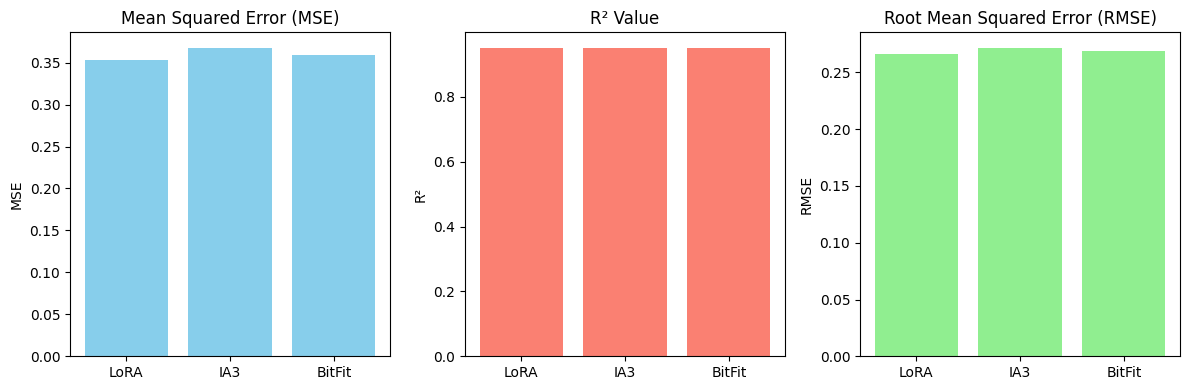

In [64]:
models = ["LoRA", "IA3", "BitFit"]
mse_values = [lora_loss, ia3_loss, bitfit_loss]
r2_values = [lora_r2, ia3_r2, bitfit_r2]
rmse_values = [lora_rmse, ia3_rmse, bitfit_rmse]
params_count = [count_trainable_params(lora_model), count_trainable_params(ia3_model), count_trainable_params(bitfit_model)]

# Plot comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.bar(models, mse_values, color="skyblue")
plt.title("Mean Squared Error (MSE)")
plt.ylabel("MSE")

plt.subplot(1, 3, 2)
plt.bar(models, r2_values, color="salmon")
plt.title("R² Value")
plt.ylabel("R²")

plt.subplot(1, 3, 3)
plt.bar(models, rmse_values, color="lightgreen")
plt.title("Root Mean Squared Error (RMSE)")
plt.ylabel("RMSE")



plt.tight_layout()
plt.show()


Model: Most Influential Points
MSE: 0.0771
R²: 0.9476
RMSE: 0.2782
--------------------
Model: Diversity based Sampling
MSE: 0.4372
R²: 0.7097
RMSE: 0.6549
--------------------
Model: Uncertainity based Sampling
MSE: 0.4181
R²: 0.7213
RMSE: 0.6417
--------------------
Model: Random Sampling
MSE: 0.4057
R²: 0.7279
RMSE: 0.6340
--------------------


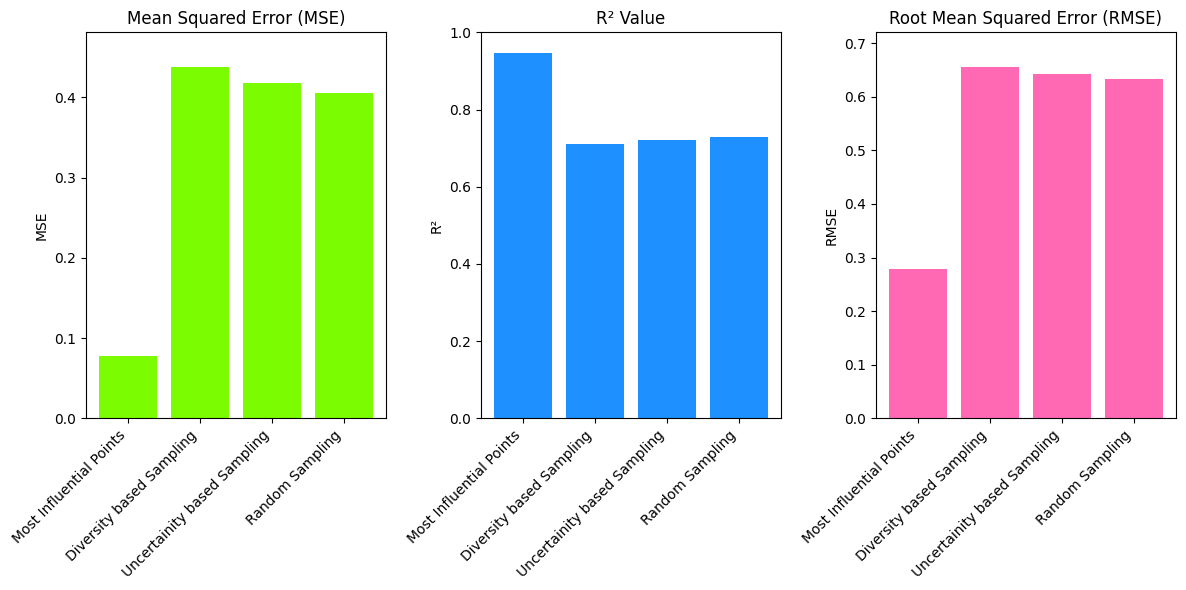

In [94]:
data_loss = [after_loss, diverse_loss, entropy_loss, random_loss]
data_r2 = [after_r2, diverse_r2, entropy_r2, random_r2]
data_rmse = [after_rmse, diverse_rmse, entropy_rmse, random_rmse]

models = ["Most Influential Points", "Diversity based Sampling", "Uncertainity based Sampling", "Random Sampling"]

# print metrics for each model
for i, model in enumerate(models):
    print(f"Model: {model}")
    print(f"MSE: {data_loss[i]:.4f}")
    print(f"R²: {data_r2[i]:.4f}")
    print(f"RMSE: {data_rmse[i]:.4f}")
    print("-"*20)

# create Subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
# Plot MSE
axes[0].set_ylim(0, max(data_loss) * 1.1)
axes[0].bar(models, data_loss, color='lawngreen')
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_ylabel('MSE')
axes[0].set_xticks(range(len(models)))  # Set tick positions
axes[0].set_xticklabels(models, rotation=45, ha='right')  # Set labels with rotation and alignment

# Plot R2
axes[1].set_ylim(0, 1.0)
axes[1].bar(models, data_r2, color='dodgerblue')
axes[1].set_title('R² Value')
axes[1].set_ylabel('R²')
axes[1].set_xticks(range(len(models)))  # Set tick positions
axes[1].set_xticklabels(models, rotation=45, ha='right')  # Set labels with rotation and alignment

# Plot RMSE
axes[2].set_ylim(0, max(data_rmse) * 1.1)
axes[2].bar(models, data_rmse, color='hotpink')
axes[2].set_title('Root Mean Squared Error (RMSE)')
axes[2].set_ylabel('RMSE')
axes[2].set_xticks(range(len(models)))  # Set tick positions
axes[2].set_xticklabels(models, rotation=45, ha='right')  # Set labels with rotation and alignment

plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()



Model: Base Regression Model
MSE: 0.5635
R²: 0.6257
RMSE: 0.7436
--------------------
Model: Unsupervised Fine-Tuning
MSE: 0.4252
R²: 0.7165
RMSE: 0.6471
--------------------
Model: Dataset augmented with most Influential Points
MSE: 0.0771
R²: 0.9476
RMSE: 0.2782
--------------------
Model: LoRA Fine-Tuning
MSE: 0.3536
R²: 0.9510
RMSE: 0.2665
--------------------


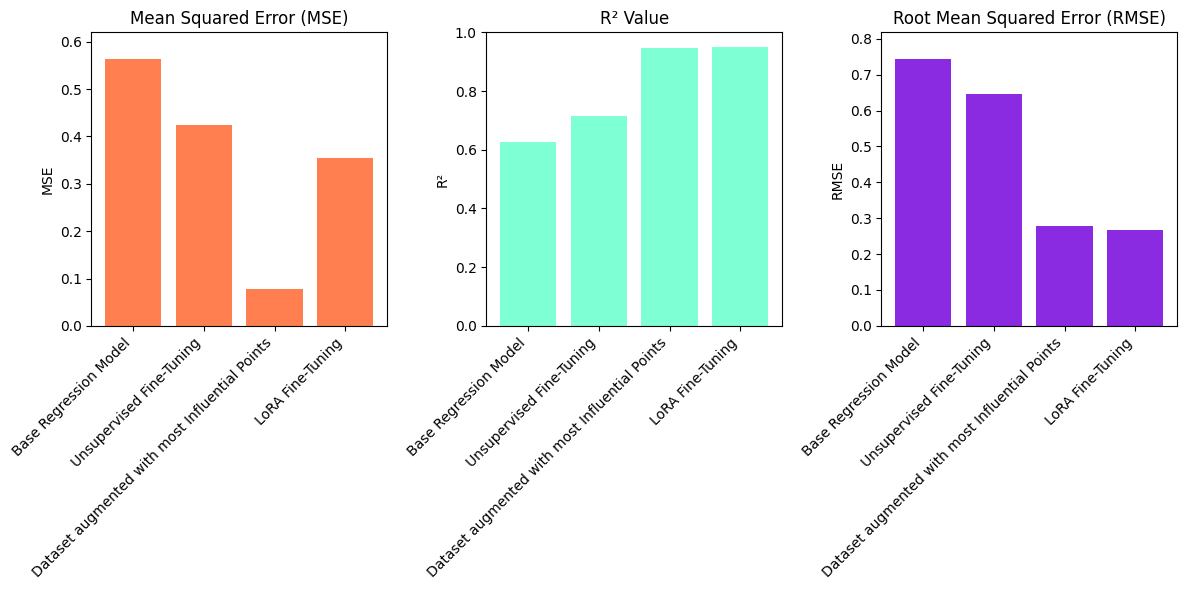

In [91]:
final_loss = [average_loss, ft_loss, after_loss, lora_loss]
final_r2 = [r2, ft_r2, after_r2, lora_r2]
final_rmse = [rmse, ft_rmse, after_rmse, lora_rmse]



models = ["Base Regression Model", "Unsupervised Fine-Tuning", "Dataset augmented with most Influential Points", "LoRA Fine-Tuning"]

# print metrics for each model
for i, model in enumerate(models):
    print(f"Model: {model}")
    print(f"MSE: {final_loss[i]:.4f}")
    print(f"R²: {final_r2[i]:.4f}")
    print(f"RMSE: {final_rmse[i]:.4f}")
    print("-"*20)


# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Plot MSE
axes[0].set_ylim(0, max(final_loss) * 1.1)
axes[0].bar(models, final_loss, color='coral')
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_ylabel('MSE')
axes[0].set_xticks(range(len(models)))  # Set tick positions
axes[0].set_xticklabels(models, rotation=45, ha='right')  # Set labels with rotation and alignment

# Plot R2
axes[1].set_ylim(0, 1.0)
axes[1].bar(models, final_r2, color='aquamarine')
axes[1].set_title('R² Value')
axes[1].set_ylabel('R²')
axes[1].set_xticks(range(len(models)))  # Set tick positions
axes[1].set_xticklabels(models, rotation=45, ha='right')  # Set labels with rotation and alignment

# Plot RMSE
axes[2].set_ylim(0, max(final_rmse) * 1.1)
axes[2].bar(models, final_rmse, color='blueviolet')
axes[2].set_title('Root Mean Squared Error (RMSE)')
axes[2].set_ylabel('RMSE')
axes[2].set_xticks(range(len(models)))  # Set tick positions
axes[2].set_xticklabels(models, rotation=45, ha='right')  # Set labels with rotation and alignment

plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()